In [85]:
import numpy as np
import matplotlib.pyplot as plt
from proofreader.utils.io import read_cremi_volume, from_h5
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
import matplotlib.pyplot as plt
import IPython

def view_volume(volume, fig_size=6.5):
    length = volume.shape[0]

    # set up
    fig = plt.figure()
    fig.set_size_inches(fig_size, fig_size)
    axes = fig.add_subplot()
    hfig = display(fig, display_id=True)

    # display
    for i in range(length):
        axes.imshow(volume[i], cmap='gray', interpolation='none',
                    filternorm=False, resample=False)
        fig.canvas.draw()
        hfig.update(fig)
        if i != length-1:
            plt.cla()
    # clean up
    IPython.display.clear_output()


In [46]:
trueA = read_cremi_volume('A',seg=True, path='../../dataset/cremi')
trueB = read_cremi_volume('B',seg=True, path='../../dataset/cremi')
trueC = read_cremi_volume('C',seg=True, path='../../dataset/cremi')

In [3]:
imgA = read_cremi_volume('A', img=True, path='../../dataset/cremi')
imgB = read_cremi_volume('B', img=True, path='../../dataset/cremi')
imgC = read_cremi_volume('C', img=True, path='../../dataset/cremi')

In [33]:
def get_classes_sorted_by_volume(vol, reverse=False, return_counts=False):

    classes, counts = np.unique(vol, return_counts=True)

    sort_indices = np.argsort(counts)
    if reverse:
        sort_indices = np.flip(sort_indices)
    classes = classes[sort_indices]
    if return_counts:
        counts = counts[sort_indices]
        return classes, counts
    return classes

In [34]:
import random
import numpy as np

def sample_square_radius(vol, radius):
    dims = len(vol.shape)
    if type(radius) != tuple:
        radius = (radius,)*dims
    assert dims == len(radius), 'radius must be specified for each dim of input, or be scalar'

    sample_slice = []
    for d in range(dims):
        r = radius[d]
        s = vol.shape[d]
        x = random.randint(r, s-r)
        sample_slice.append(slice(x-r,x+r))
    sample_slice = tuple(sample_slice)
    return vol[sample_slice]


In [79]:

classes, counts = get_classes_sorted_by_volume(trueC, return_counts=True, reverse=True)



In [59]:
# get negative example
i = 50
vol = trueC.copy()
c = classes[i]
print(counts[i])

770366


In [68]:

vol = trueC.copy()

(6, 1250, 1250) (57, 1250, 1250)


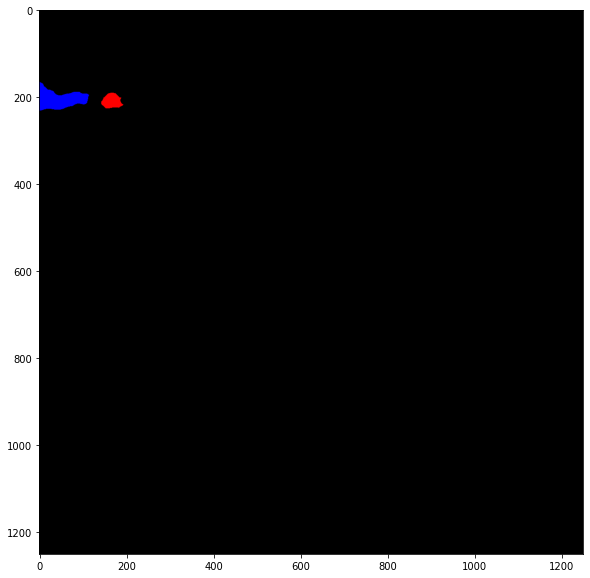

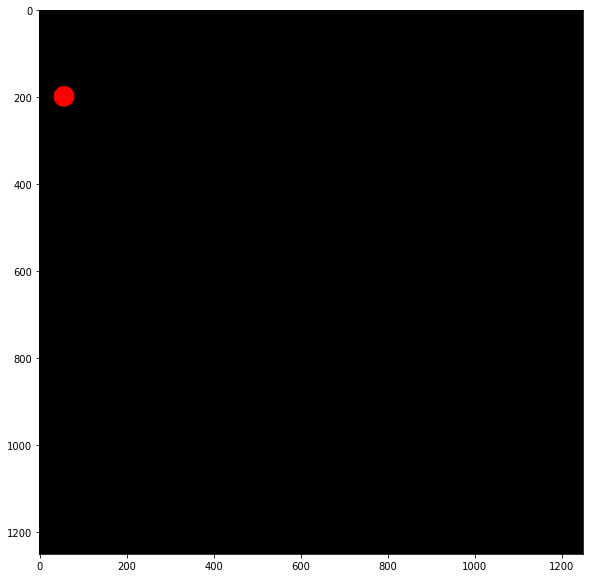

[10987] 12262


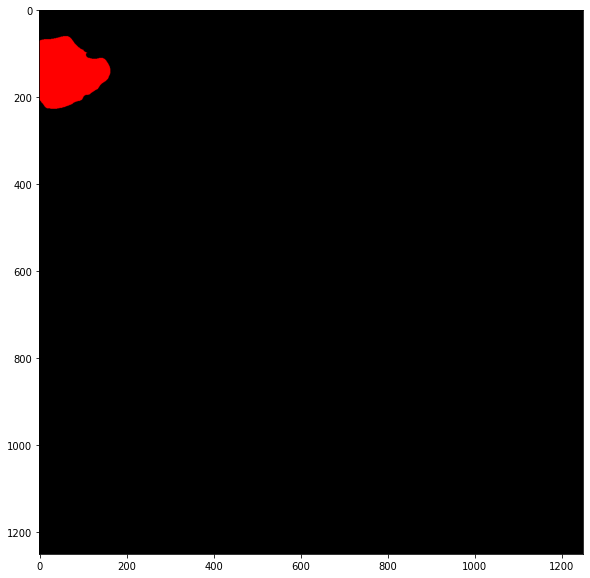

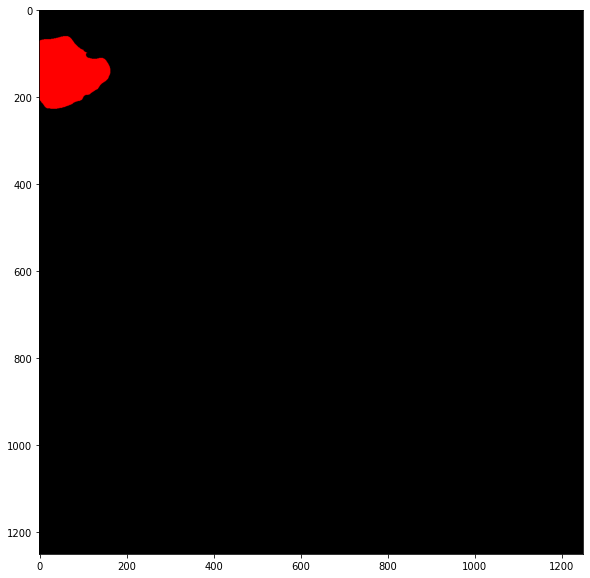

In [207]:
import random
import math
import cc3d
from proofreader.utils.all import split_int
from proofreader.utils.data import arg_where_range, circular_mask, crop_where
from proofreader.utils.vis import view_segmentation, grid_volume
from skimage import color
# Negative
# 1. Define a distance
# 2. Select neruite, (some label class, c)
# 3. Fracture neurite by dropping some z-slices to drop
# 4. Do connected compoent analysis on "top" fragment and select one fragment
# 4. Get closest point on other side of the fracture
# 5. Find all neurites with distnce D from that point on fracture cross section
# 6. Pick 1 neurite of above set

vol = trueC.copy()

# 1. Define a distance
radius = 24 # in voxels
margin = 3 # margin (in z-slices) from min and max locations to drop slices
num_slices = 4 # number of slices to drop
# context_slices = 10 # number of slice on either side of drop slices, full for now

# 2. Select neruite, (some label class, c)
top_c = classes[100] # will be the "top" fragment

# 3. Fracture neurite by dropping some z-slices to drop
mins, maxs = arg_where_range(vol == top_c)
zmin, zmax = mins[0], maxs[0] # get z range of neurite
z_loc = random.randint(zmin + margin, zmax - margin)
a,b = split_int(num_slices)
drop_start, drop_end = z_loc-a, z_loc+b # beginng and end of drop indices

# ensure fragment
drop_start, drop_end  = 64, 68
top_vol_section = vol[zmin:drop_start]
bot_vol_section = vol[drop_end:]
print(top_vol_section.shape, bot_vol_section.shape)
# 4. Do connected component relabeling to ensure only one fragment on top
top_vol_section = vol[zmin:drop_start]
top_vol_section[top_vol_section != top_c] = 0
top_vol_section_relabeled = cc3d.connected_components(top_vol_section)
top_classes_relabeled = list(np.unique(top_vol_section_relabeled))
top_classes_relabeled.remove(0)
relabeled_top_c = random.choice(top_classes_relabeled) # select new top class from relabeled top section

# 5. Get midpoint of neurite on top cross section
top_border = np.squeeze(top_vol_section_relabeled[-1:]).copy()
bot_border = np.squeeze(bot_vol_section[:1]).copy()
# get mid point of neurite on 2D top cross section, use the relabeled top section
mins, maxs = arg_where_range(top_border == relabeled_top_c)
mp_y, mp_x = [(mi + ma) // 2 for mi,ma in zip(mins,maxs)] # mid point

view_segmentation([top_border])

# 6. Find all neurites with distnce D from that point on bottom cross section
mask = circular_mask(bot_border.shape[0], bot_border.shape[1], center=(mp_x, mp_y), radius=radius)
bot_border[~mask] = 0

view_segmentation([bot_border])

mismatch_classes = list(np.unique(bot_border))
# 6. Pick 1 neurite of above set
assert mismatch_classes[0] == 0, 'first class should be 0, otherwise something went wrong'
mismatch_classes = [ x for x in mismatch_classes if not x in [0, top_c] ] # remove 0 and top class lables
print(mismatch_classes, top_c)
if len(mismatch_classes) == 0:
    print('could not find bottom label retrying')
# maybe could select here based on on cross-sectional volume
bot_c = random.choice(mismatch_classes) # select bottom neurite class

# 4. Do connected component relabeling to ensure only one fragment on bottom
# Get bottom neurite
bot_vol_section[bot_vol_section != bot_c] = 0
view_segmentation(bot_vol_section)
bot_vol_section_relabeled = cc3d.connected_components(bot_vol_section)
bot_classes_relabeled = list(np.unique(bot_vol_section_relabeled))
bot_classes_relabeled.remove(0)
relabeled_bot_c = 0 #TODO take one which contains mid point of top neurite
view_segmentation(bot_vol_section_relabeled)
